# blood_Shapley_analysis_top_100

#### This notebook:
* Load blood data
* load top ranked cpgs
* load XGboost model from fits with top100
* Calcualte Shapley scores on Test data with XGboost model
* Plot results

#### Conclusions:

* Absolute Shap somewhat similar to ridge coefficients 
* By far the most import is cg169675657, as is the case with ridge coefficents(gene ELOVL2))

#### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import os
import pickle
import warnings
warnings.simplefilter('ignore')
plt.rcdefaults()

#### Import our modules, 
* needs to have age_predict package the we created installed.

In [2]:
import age_predict.Loading_EWAS_Aging_Data as le
import age_predict.Regression as rg
import age_predict.Pickle_unpickle as pu

In [3]:
# View working directory
os.getcwd()

'/Users/dcox/Desktop/EWAS-organized/blood/modeling_linear_XGboost'

#### Set paths

In [4]:
data_path = '../../data/'
cpg_path = '../saved_features/'
save_models_path = '../saved_models/'

#### Get Saved imputed whole blood data 2259 cpgs
* The dataframes imported here were created with the "wb_feature_selection_by_XGB_importance_scores" notebook

In [5]:
df_train = pd.read_csv(data_path + 'df_p_working_ranked.csv', index_col=0)
df_test = pd.read_csv(data_path +  'df_p_saved_ranked.csv', index_col=0)

#### Get Saved blood cpg rankings
* The list of top ranked cpgs imported here was created with the "wb_feature_selection_by_XGB_importance_scores" notebook and pickled

In [6]:
cpgs_XGboost_blood_ranked = pu.get_pickled_object(cpg_path + 'cpgs_XGboost_blood_ranked')

In [7]:
top_100 = cpgs_XGboost_blood_ranked[:100]
top_1000 = cpgs_XGboost_blood_ranked[:1000]

In [8]:
s = pd.Series(list(df_train.age) + list(df_test.age))

#### Looking at the age distributions in the data

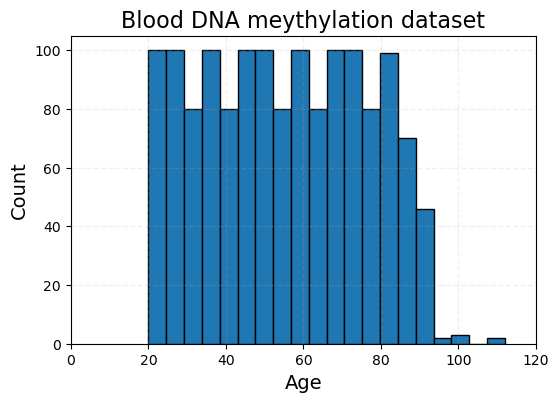

In [9]:
# Histogram of ages in train + test data
plt.figure(figsize=(6,4))
s.hist(bins=20,histtype='bar', ec='black' )
plt.xlabel('Age', fontsize=14)
plt.xlim(0,120)
plt.ylabel('Count', fontsize=14)
plt.grid(True, lw=1, ls = '--', alpha=0.2)
plt.title('Blood DNA meythylation dataset', fontsize=16)
plt.show()

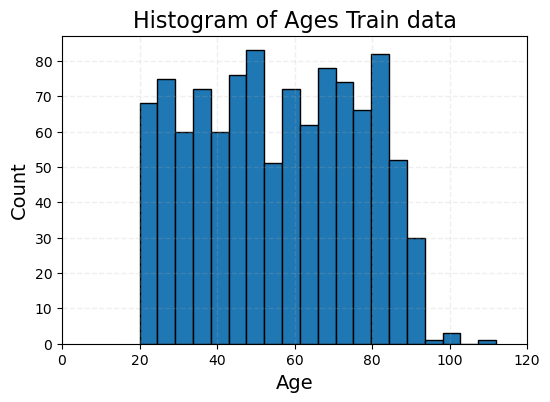

In [10]:
# Histogram of ages in train data
plt.figure(figsize=(6,4))
df_train.age.hist(bins=20,histtype='bar', ec='black' )
plt.xlabel('Age', fontsize=14)
plt.xlim(0,120)
plt.ylabel('Count', fontsize=14)
plt.grid(True, lw=1, ls = '--', alpha=0.2)
plt.title('Histogram of Ages Train data', fontsize=16)
plt.show()

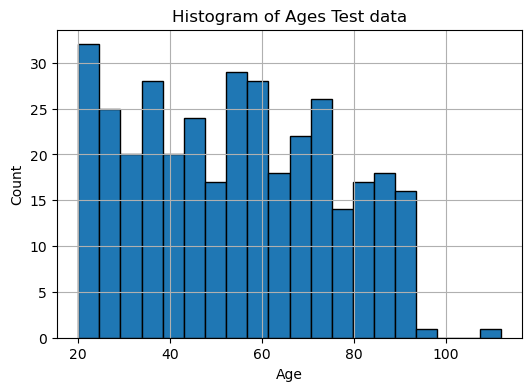

In [11]:
# Histogram of ages in test data
plt.figure(figsize=(6,4))
df_test.age.hist(bins=20, histtype='bar', ec='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Test data')
plt.show()

In [12]:
df_train

,tissue,age,cg04875128,cg16867657,cg14361627,cg24724428,cg00292135,cg04208403,cg24079702,cg11649376,cg23500537,cg08097417,cg23744638,cg06639320,cg17621438,cg21572722,cg04955333,cg09809672,cg07553761,cg22454769,cg22736354,cg19344626,cg07927379,cg07850154,cg08453194,cg08262002,cg02046143,cg01763090,cg19722847,cg10917602,cg07082267,cg23606718,cg16932827,cg03032497,cg02933228,cg18651026,cg05308819,cg16762684,cg21406967,cg03607117,cg09692396,cg07955995,cg18877361,cg25410668,cg25256723,cg05331060,cg06540876,cg12252865,cg18933331,cg10221746,...,cg14807793,cg08832136,cg02117271,cg06128598,cg05005113,cg10117562,cg13178798,cg21274274,cg00138525,cg26685941,cg18450254,cg27315497,cg00521130,cg13633679,cg22299101,cg21901718,cg09323835,cg03575969,cg12824192,cg12477923,cg02625929,cg18530950,cg12126344,cg09798418,cg14301859,cg10798225,cg03783058,cg19462712,cg01830463,cg17954142,cg01752898,cg14328457,cg25677688,cg19081662,cg22487242,cg14192299,cg14386126,cg17994379,cg27551910,cg17842066,cg23207054,cg05498785,cg01881287,cg27624721,cg04293489,cg00473462,cg22580512,cg20965017,cg06373816,cg24167372
GSM2334366,whole blood,94,0.312,0.875,0.187,0.531000,0.184,0.538,0.597,0.483,0.504,0.173,0.593,0.594,0.260,0.591,0.660,0.424,0.433,0.770,0.349,0.647000,0.130,0.362,0.361,0.490,0.213,0.179,0.131,0.752,0.377,0.294,0.835,0.293,0.709,0.471,0.509,0.011000,0.439,0.194,0.277,0.108,0.761,0.597,0.805,0.049000,0.568,0.810000,0.448,0.596,...,0.576,0.968,0.727,0.907,0.064,0.597,0.564,0.644,0.044,0.262,0.316000,0.535,0.095,0.856,0.012,0.182000,0.703,0.703,0.073000,0.613,0.148,0.028,0.811,0.014,0.700,0.718,0.028,0.854,0.638,0.863,0.241000,0.249,0.902,0.847,0.961,0.783,0.446,0.066,0.568000,0.069,0.695,0.933,0.971,0.941,0.601,0.035,0.858000,0.975000,0.840,0.338
GSM989863,whole blood,101,0.330,0.855,0.302,0.370000,0.201,0.496,0.521,0.539,0.513,0.249,0.340,0.619,0.164,0.514,0.599,0.315,0.388,0.751,0.389,0.573000,0.105,0.220,0.343,0.412,0.150,0.246,0.070,0.454,0.338,0.151,0.650,0.307,0.696,0.457,0.459,0.012000,0.272,0.096,0.201,0.107,0.603,0.652,0.554,0.021000,0.476,0.667000,0.332,0.556,...,0.506,0.949,0.558,0.810,0.065,0.573,0.538,0.405,0.021,0.145,0.123000,0.406,0.106,0.844,0.010,0.030000,0.550,0.546,0.052000,0.465,0.116,0.037,0.771,0.023,0.719,0.642,0.032,0.859,0.663,0.855,0.400000,0.130,0.925,0.896,0.893,0.948,0.603,0.047,0.480000,0.057,0.518,0.974,0.792,0.914,0.481,0.028,0.580000,0.976000,0.823,0.136
GSM1443696,whole blood,99,0.375,0.731,0.382,0.304000,0.212,0.530,0.510,0.596,0.584,0.251,0.426,0.579,0.214,0.482,0.612,0.250,0.390,0.723,0.375,0.354000,0.089,0.278,0.357,0.614,0.126,0.264,0.054,0.571,0.325,0.254,0.611,0.329,0.713,0.507,0.437,0.003000,0.281,0.180,0.233,0.200,0.551,0.663,0.714,0.027000,0.580,0.721000,0.350,0.615,...,0.518,0.972,0.690,0.856,0.050,0.703,0.584,0.031,0.026,0.114,0.146000,0.386,0.082,0.822,0.008,0.034000,0.708,0.603,0.020000,0.494,0.101,0.059,0.735,0.013,0.682,0.733,0.021,0.848,0.693,0.935,0.081000,0.140,0.989,0.925,0.876,0.888,0.636,0.047,0.624000,0.037,0.519,0.965,0.834,0.969,0.547,0.026,0.579000,0.972000,0.836,0.515
GSM1069241,whole blood,99,0.375,0.731,0.382,0.304000,0.212,0.530,0.510,0.596,0.584,0.251,0.426,0.579,0.214,0.482,0.612,0.250,0.390,0.723,0.375,0.354000,0.089,0.278,0.357,0.614,0.126,0.264,0.054,0.571,0.325,0.254,0.611,0.329,0.713,0.507,0.437,0.003000,0.281,0.180,0.233,0.200,0.551,0.663,0.714,0.027000,0.580,0.721000,0.350,0.615,...,0.518,0.972,0.690,0.856,0.050,0.703,0.584,0.031,0.026,0.114,0.146000,0.386,0.082,0.822,0.008,0.034000,0.708,0.603,0.020000,0.494,0.101,0.059,0.735,0.013,0.682,0.733,0.021,0.848,0.693,0.935,0.081000,0.140,0.989,0.925,0.876,0.888,0.636,0.047,0.624000,0.037,0.519,0.965,0.834,0.969,0.547,0.026,0.579000,0.972000,0.836,0.515
GSM1572442,whole blood,112,0.485,0.839,0.318,0.242941,0.291,0.443,0.388,0.536,0.668,0.222,0.410,0.544,0.449,0.609,0.656,0.451,0.395,0.563,0.343,0.708941,0.169,0.559,0.236,0.359,0.227,0.305,0.035,0.461,0.336,0.302,0.566,0.370,0.713,0.552,0.396,0.023000,0.249,0.053,0.223,0.232,0.625,0.746,0.

In [13]:
df_test

,tissue,age,cg04875128,cg16867657,cg14361627,cg24724428,cg00292135,cg04208403,cg24079702,cg11649376,cg23500537,cg08097417,cg23744638,cg06639320,cg17621438,cg21572722,cg04955333,cg09809672,cg07553761,cg22454769,cg22736354,cg19344626,cg07927379,cg07850154,cg08453194,cg08262002,cg02046143,cg01763090,cg19722847,cg10917602,cg07082267,cg23606718,cg16932827,cg03032497,cg02933228,cg18651026,cg05308819,cg16762684,cg21406967,cg03607117,cg09692396,cg07955995,cg18877361,cg25410668,cg25256723,cg05331060,cg06540876,cg12252865,cg18933331,cg10221746,...,cg14807793,cg08832136,cg02117271,cg06128598,cg05005113,cg10117562,cg13178798,cg21274274,cg00138525,cg26685941,cg18450254,cg27315497,cg00521130,cg13633679,cg22299101,cg21901718,cg09323835,cg03575969,cg12824192,cg12477923,cg02625929,cg18530950,cg12126344,cg09798418,cg14301859,cg10798225,cg03783058,cg19462712,cg01830463,cg17954142,cg01752898,cg14328457,cg25677688,cg19081662,cg22487242,cg14192299,cg14386126,cg17994379,cg27551910,cg17842066,cg23207054,cg05498785,cg01881287,cg27624721,cg04293489,cg00473462,cg22580512,cg20965017,cg06373816,cg24167372
GSM1345728,whole blood,38,0.129,0.606,0.108,0.162,0.053,0.645,0.312,0.638,0.399,0.112,0.697,0.388,0.265,0.359,0.785,0.464,0.246,0.475000,0.240,0.726,0.040,0.330,0.471,0.534,0.314,0.098,0.157,0.671,0.438,0.072,0.912,0.155,0.783,0.578,0.570,0.058,0.444,0.064,0.265,0.052,0.741,0.608,0.617,0.030,0.506,0.829,0.429,0.704,...,0.575,0.936,0.613,0.858,0.033,0.626,0.590,0.453,0.032,0.219000,0.292000,0.508,0.088000,0.846,0.009,0.017,0.702,0.735,0.051,0.577,0.078,0.043,0.838,0.034,0.747,0.737,0.022,0.864,0.833,0.847,0.215,0.101,0.842000,0.862,0.938,0.927,0.678,0.052,0.494,0.092,0.591,0.942,0.840,0.925,0.513,0.031,0.837,0.979,0.857,0.385
GSM1425726,whole blood,79,0.317,0.847,0.125,0.610,0.096,0.557,0.612,0.569,0.664,0.102,0.538,0.674,0.137,0.770,0.613,0.393,0.345,0.818000,0.368,0.330,0.064,0.205,0.337,0.487,0.292,0.132,0.128,0.705,0.331,0.289,0.773,0.247,0.749,0.379,0.498,0.003,0.399,0.059,0.174,0.049,0.612,0.879,0.515,0.069,0.598,0.851,0.474,0.753,...,0.557,0.970,0.626,0.790,0.035,0.625,0.558,0.044,0.037,0.127000,0.180000,0.479,0.093000,0.795,0.010,0.061,0.566,0.598,0.058,0.482,0.093,0.055,0.817,0.010,0.726,0.638,0.031,0.785,0.426,0.894,0.062,0.174,0.750000,0.905,0.879,0.982,0.632,0.053,0.491,0.038,0.539,0.943,0.896,0.941,0.588,0.040,0.906,0.956,0.891,0.409
GSM1886430,whole blood,24,0.089,0.464,0.103,0.172,0.060,0.607,0.166,0.749,0.380,0.093,0.856,0.345,0.555,0.361,0.818,0.637,0.151,0.345000,0.224,0.843,0.037,0.597,0.459,0.718,0.312,0.107,0.233,0.755,0.588,0.069,0.935,0.228,0.782,0.661,0.625,0.081,0.517,0.028,0.393,0.042,0.735,0.545,0.821,0.048,0.623,0.758,0.572,0.680,...,0.568,0.959,0.686,0.870,0.056,0.646,0.586,0.100,0.043,0.367000,0.544000,0.603,0.072000,0.821,0.010,0.039,0.754,0.658,0.088,0.684,0.116,0.051,0.827,0.020,0.774,0.727,0.030,0.862,0.789,0.870,0.090,0.150,0.872000,0.901,0.890,0.909,0.625,0.030,0.544,0.051,0.598,0.909,0.790,0.968,0.528,0.027,0.901,0.963,0.852,0.544
GSM2337042,whole blood,25,0.034,0.458,0.087,0.137,0.055,0.652,0.195,0.719,0.352,0.059,0.857,0.292,0.354,0.334,0.790,0.696,0.177,0.346000,0.173,0.856,0.030,0.444,0.469,0.752,0.347,0.069,0.169,0.723,0.497,0.067,0.890,0.148,0.841,0.618,0.648,0.091,0.438,0.049,0.349,0.027,0.827,0.452,0.811,0.097,0.665,0.827,0.600,0.741,...,0.566,0.956,0.718,0.889,0.033,0.684,0.527,0.415,0.028,0.295000,0.380000,0.534,0.123000,0.842,0.010,0.040,0.751,0.701,0.071,0.622,0.058,0.049,0.834,0.023,0.792,0.818,0.046,0.861,0.798,0.801,0.373,0.121,0.988000,0.849,0.961,0.862,0.611,0.028,0.522,0.063,0.647,0.956,0.885,0.906,0.560,0.028,0.813,0.968,0.880,0.483
GSM1886440,whole blood,23,0.302,0.509,0.172,0.263,0.027,0.653,0.261,0.590,0.488,0.058,0.897,0.339,0.575,0.394,0.847,0.685,0.122,0.267000,0.285,0.792,0.011,0.594,0.383,0.728,0.358,0.184,0.249,0.693,0.516,0.154,0.942,0.168,0.708,0.585,0.636,0.074,0.393,0.042,0.363,0.037,0.679,0.548,0.740,0.040,0.626,0.833,0.573,0.655,...,0.528,0.940,0.689,0.796,0.043,0.572,0.592,0.172,0.023

## Looking at Shapley Score of top 100 cpgs

In [17]:
cpgs_XGboost_blood_ranked = pu.get_pickled_object(cpg_path + 'cpgs_XGboost_blood_ranked' )

#### Get top 100 cpgs

In [18]:
top_100 = cpgs_XGboost_blood_ranked[:100]

#### Get saved XGboost model

In [91]:
XG_100 = pu.get_pickled_object(save_models_path + 'wb_mod_XG_100')
wb_mod_ridge_100 = pu.get_pickled_object(save_models_path + 'wb_mod_ridge_100')

In [20]:
X_test = df_test[top_100]

In [21]:
import xgboost
import shap

# Getting Shap avalues for top 100 cpgs
explainer = shap.Explainer(XG_100)
shap_values = explainer(X_test)

In [22]:
# converting to means of absolute value for each cpg
abs_shap_values = np.abs(shap_values.values)
mean_shap = abs_shap_values.mean(axis=0)

In [23]:
# Making a df with the cpgs ordered by Shap value
df_shap = pd.DataFrame({'cpg':X_test.columns, 'mean_abs_shape': mean_shap})
df_shap_sorted = df_shap.sort_values('mean_abs_shape', ascending=False)
df_shap_sorted

,cpg,mean_abs_shape
1,cg16867657,6.520807
0,cg04875128,1.556247
2,cg14361627,1.523263
3,cg24724428,1.287609
9,cg08097417,1.008864
...,...,...
96,cg15957394,0.026995
76,cg19784428,0.025358
43,cg05331060,0.021958
98,cg14692377,0.009936


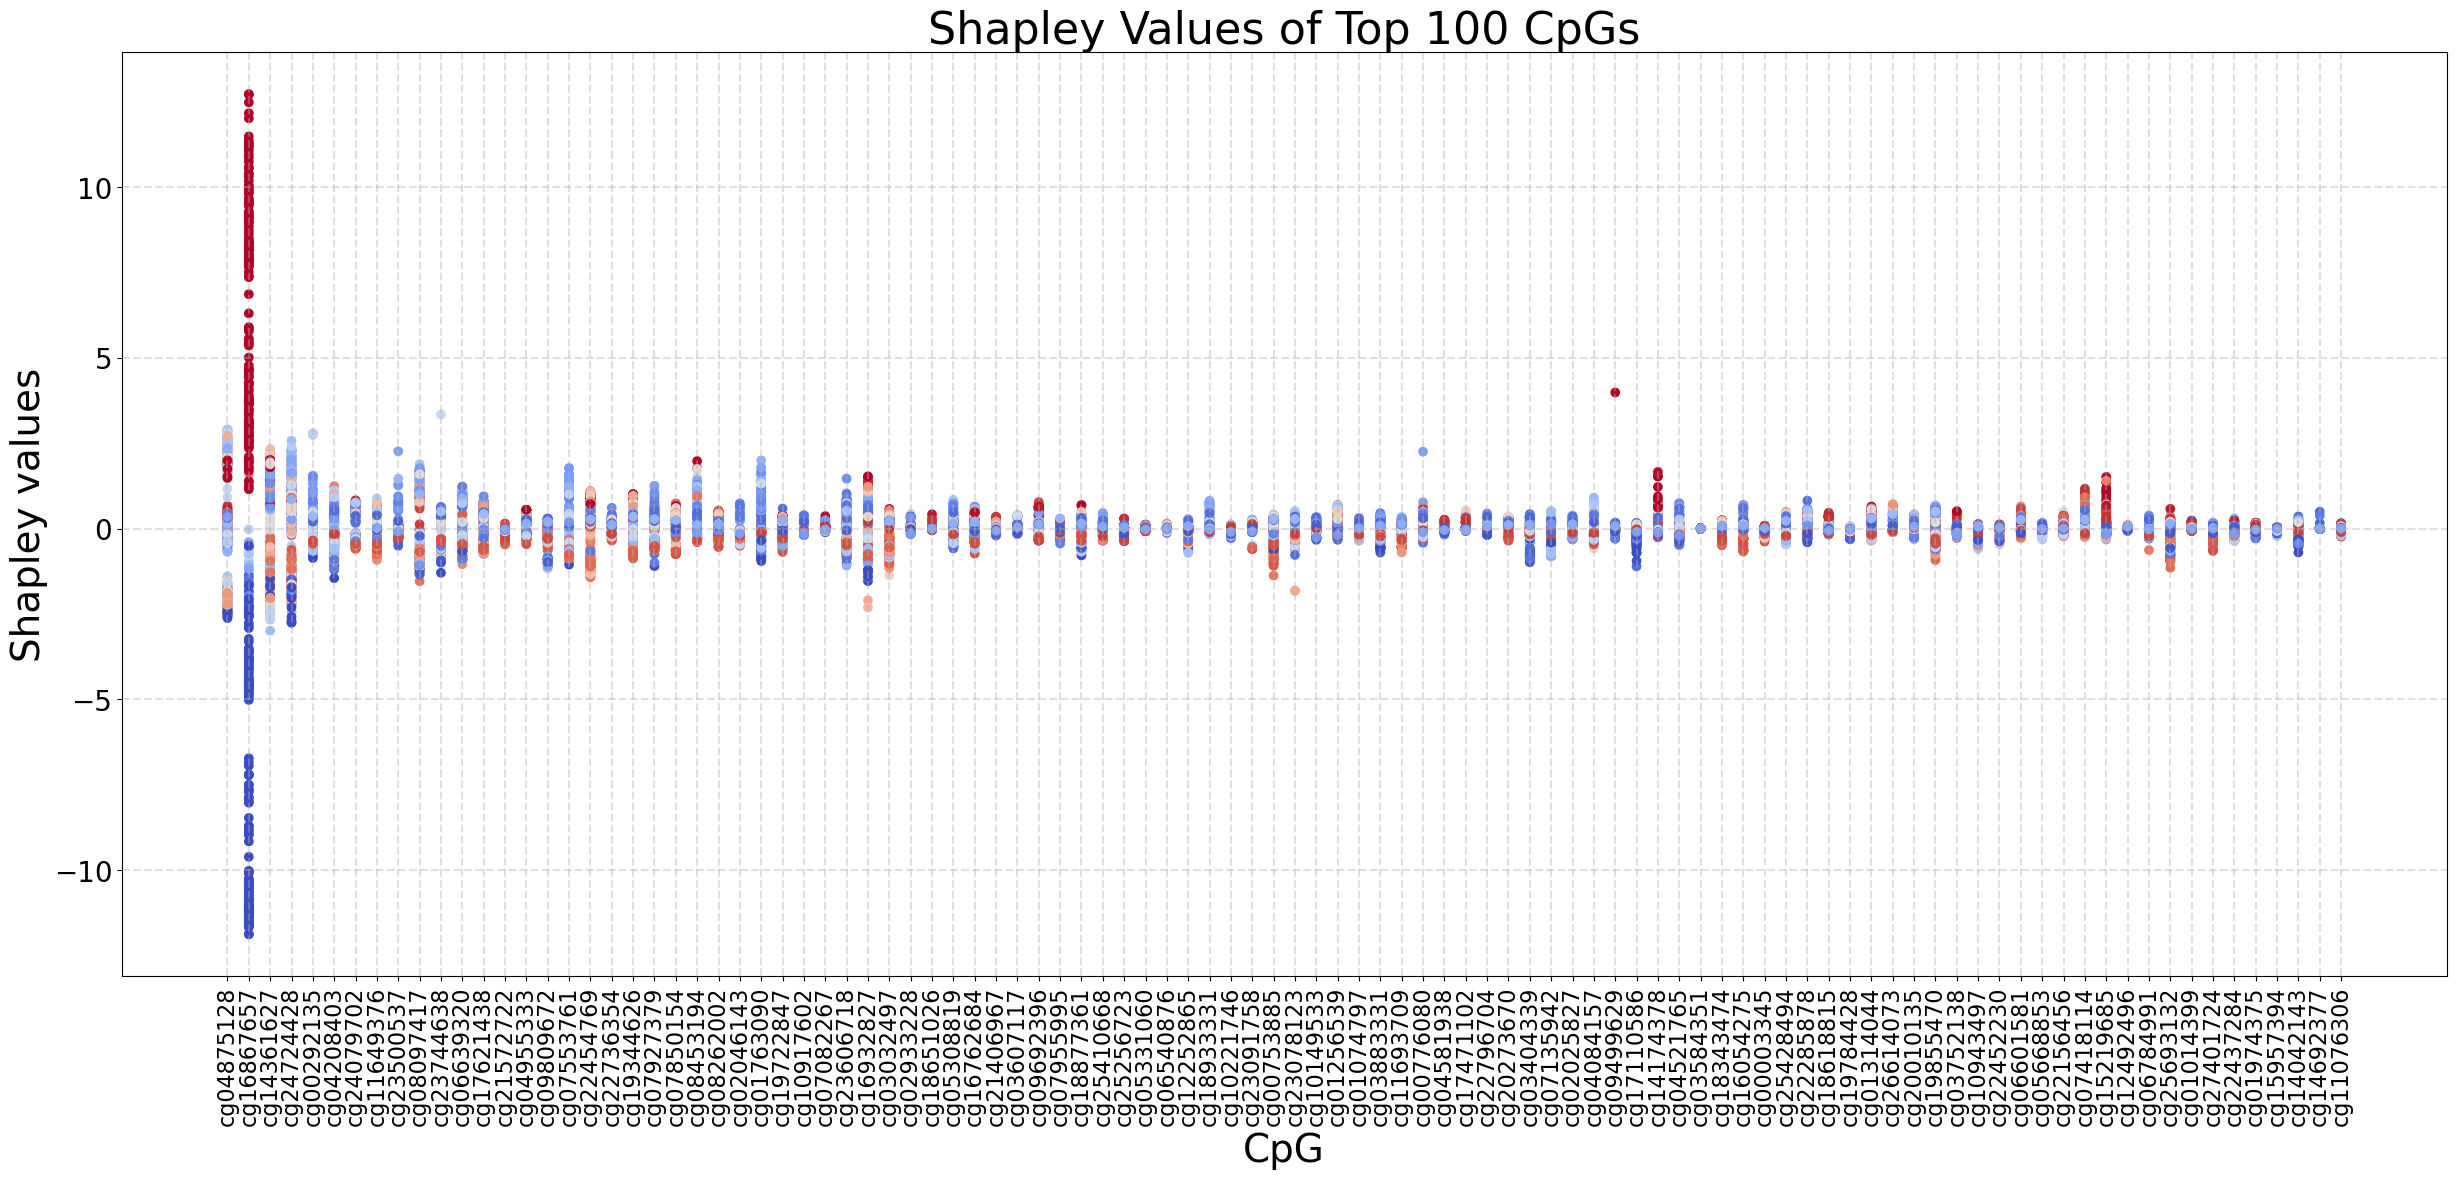

In [83]:
# plotting Shapley Scores for top 100 cpgs

f_size=28

fig, ax = plt.subplots(1, 1, figsize = (30, 12))
for col in df.columns:
    ax.scatter(df.index, df[col], c =df[col] , cmap='coolwarm')

ax.set_title('Shapley Values of Top 100 CpGs', fontsize=32)
ax.set_ylabel('Shapley values', fontsize=f_size)
ax.set_xlabel('CpG', fontsize=f_size)
ax.tick_params(labelsize = 16, rotation=90)
ax.tick_params('y',labelsize = 20, rotation=0)
ax.grid(True, lw=1.5, ls='--', alpha=0.4)
plt.show()

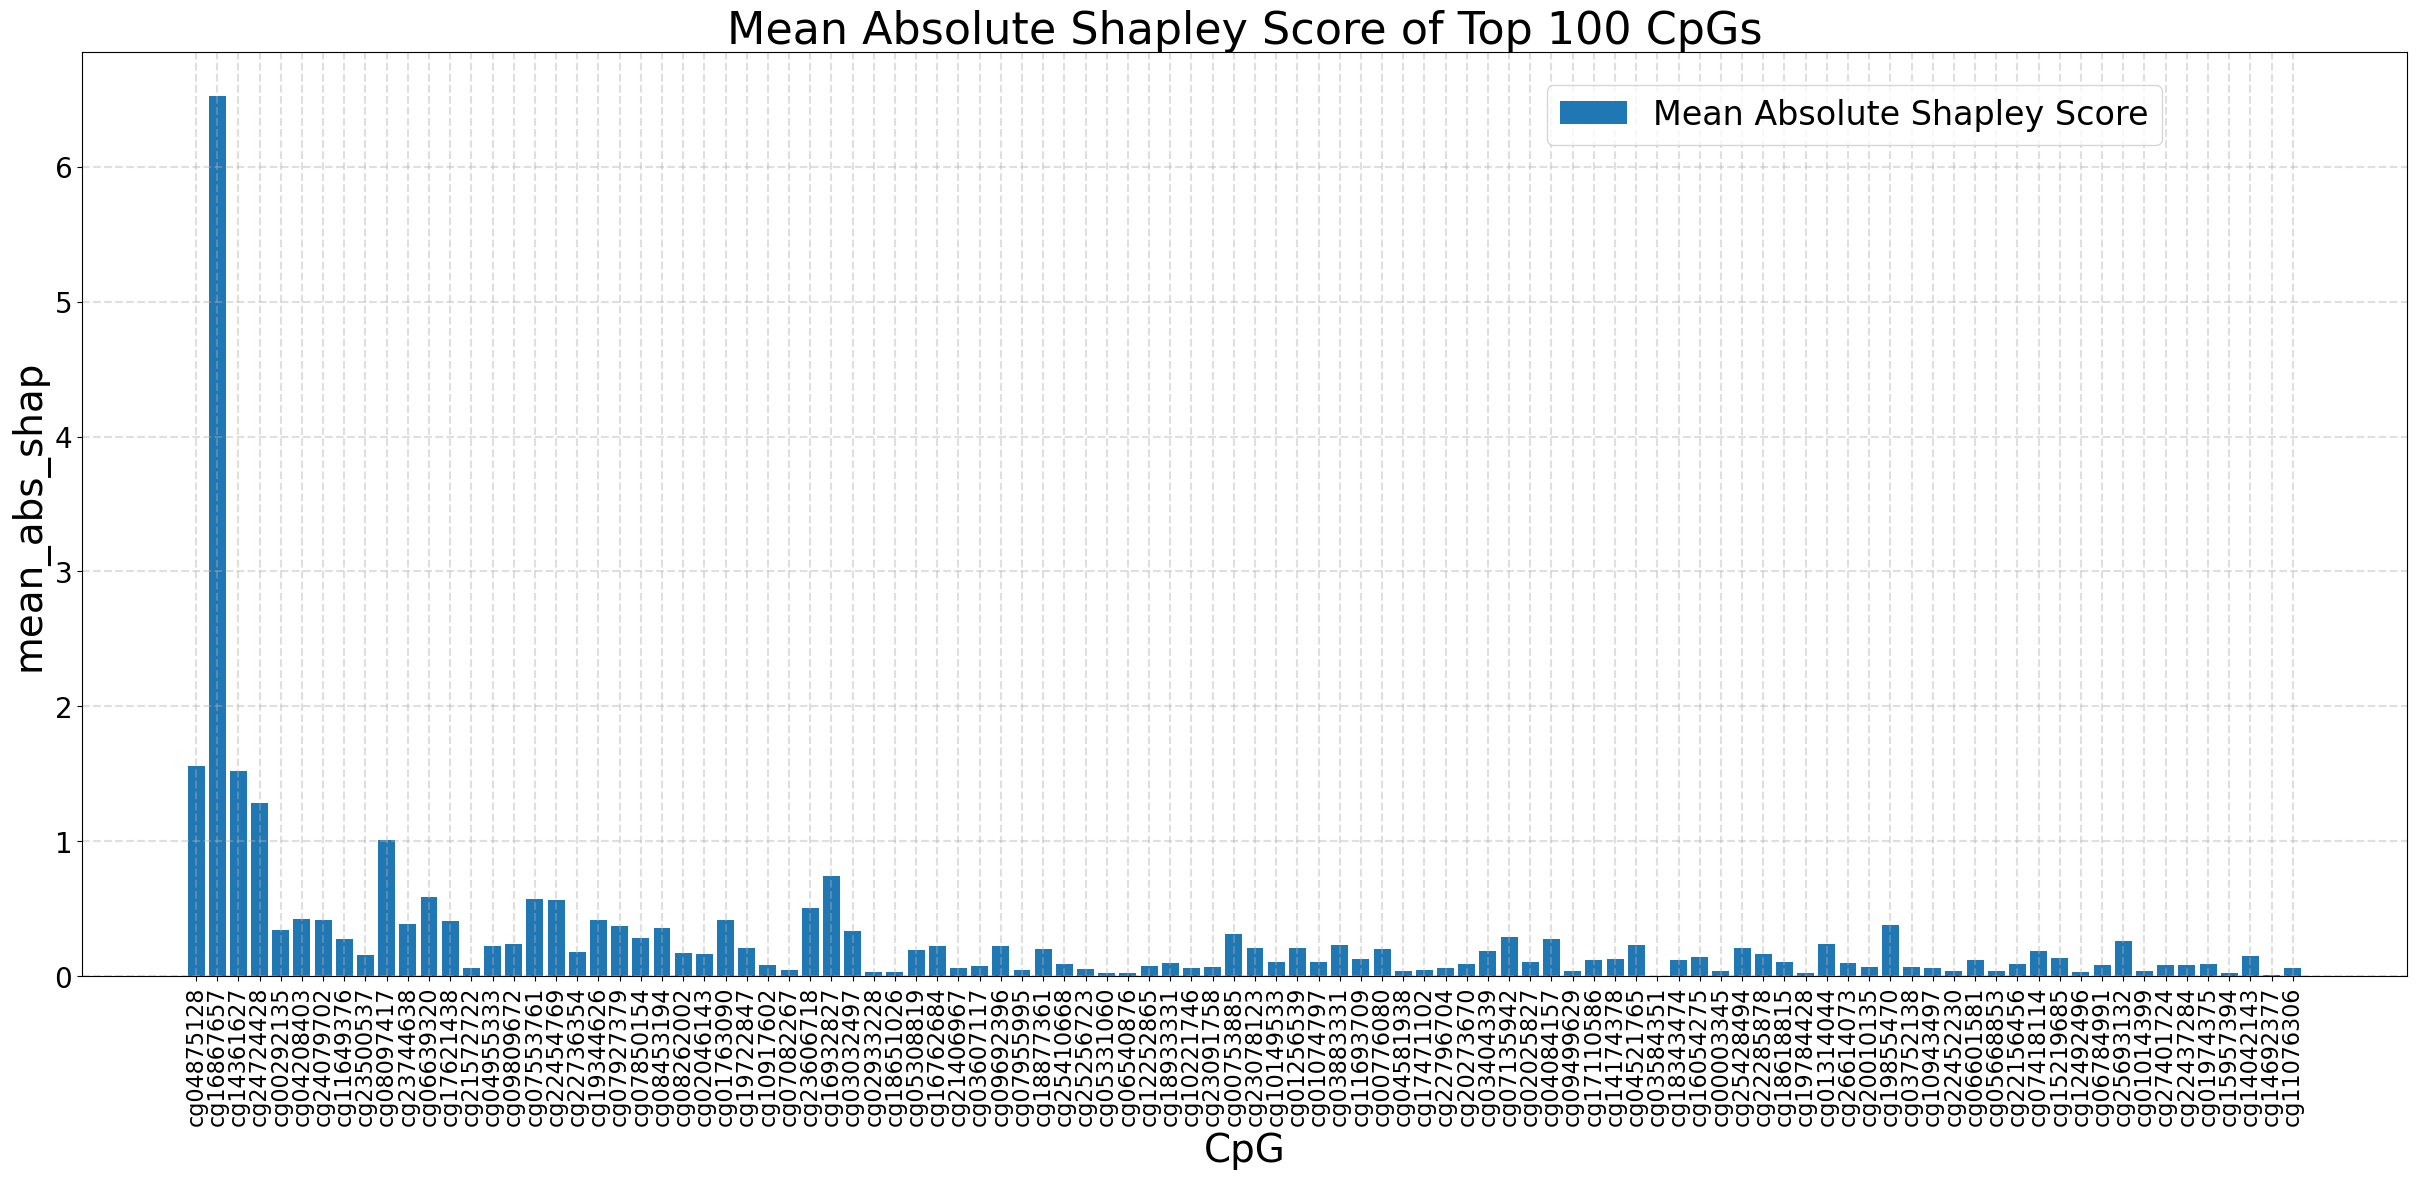

In [84]:
# plotting Mean absolute Shapley Score for top 100 cpgs

f_size=28

fig, ax = plt.subplots(1, 1, figsize = (30, 12))
ax.bar(top_100,df_shap.mean_abs_shape, label= 'Mean Absolute Shapley Score')
ax.set_title('Mean Absolute Shapley Score of Top 100 CpGs', fontsize=32)
ax.set_ylabel('mean_abs_shap', fontsize=f_size)
ax.set_xlabel('CpG', fontsize=f_size)
ax.tick_params(labelsize = 16, rotation=90)
ax.tick_params('y',labelsize = 20, rotation=0)
#ax.set_ylim(0, 2)
ax.legend(loc=(0.63,0.9), fontsize=24)
plt.grid(True, lw=1.5, ls='--', alpha=0.4)
plt.show()

### Looking at ridge coefficeint to compare to Shapely scores

In [106]:
ridge_100_coeficients = wb_mod_ridge_100.coef_
ridge_100_intercept = wb_mod_ridge_100.intercept_

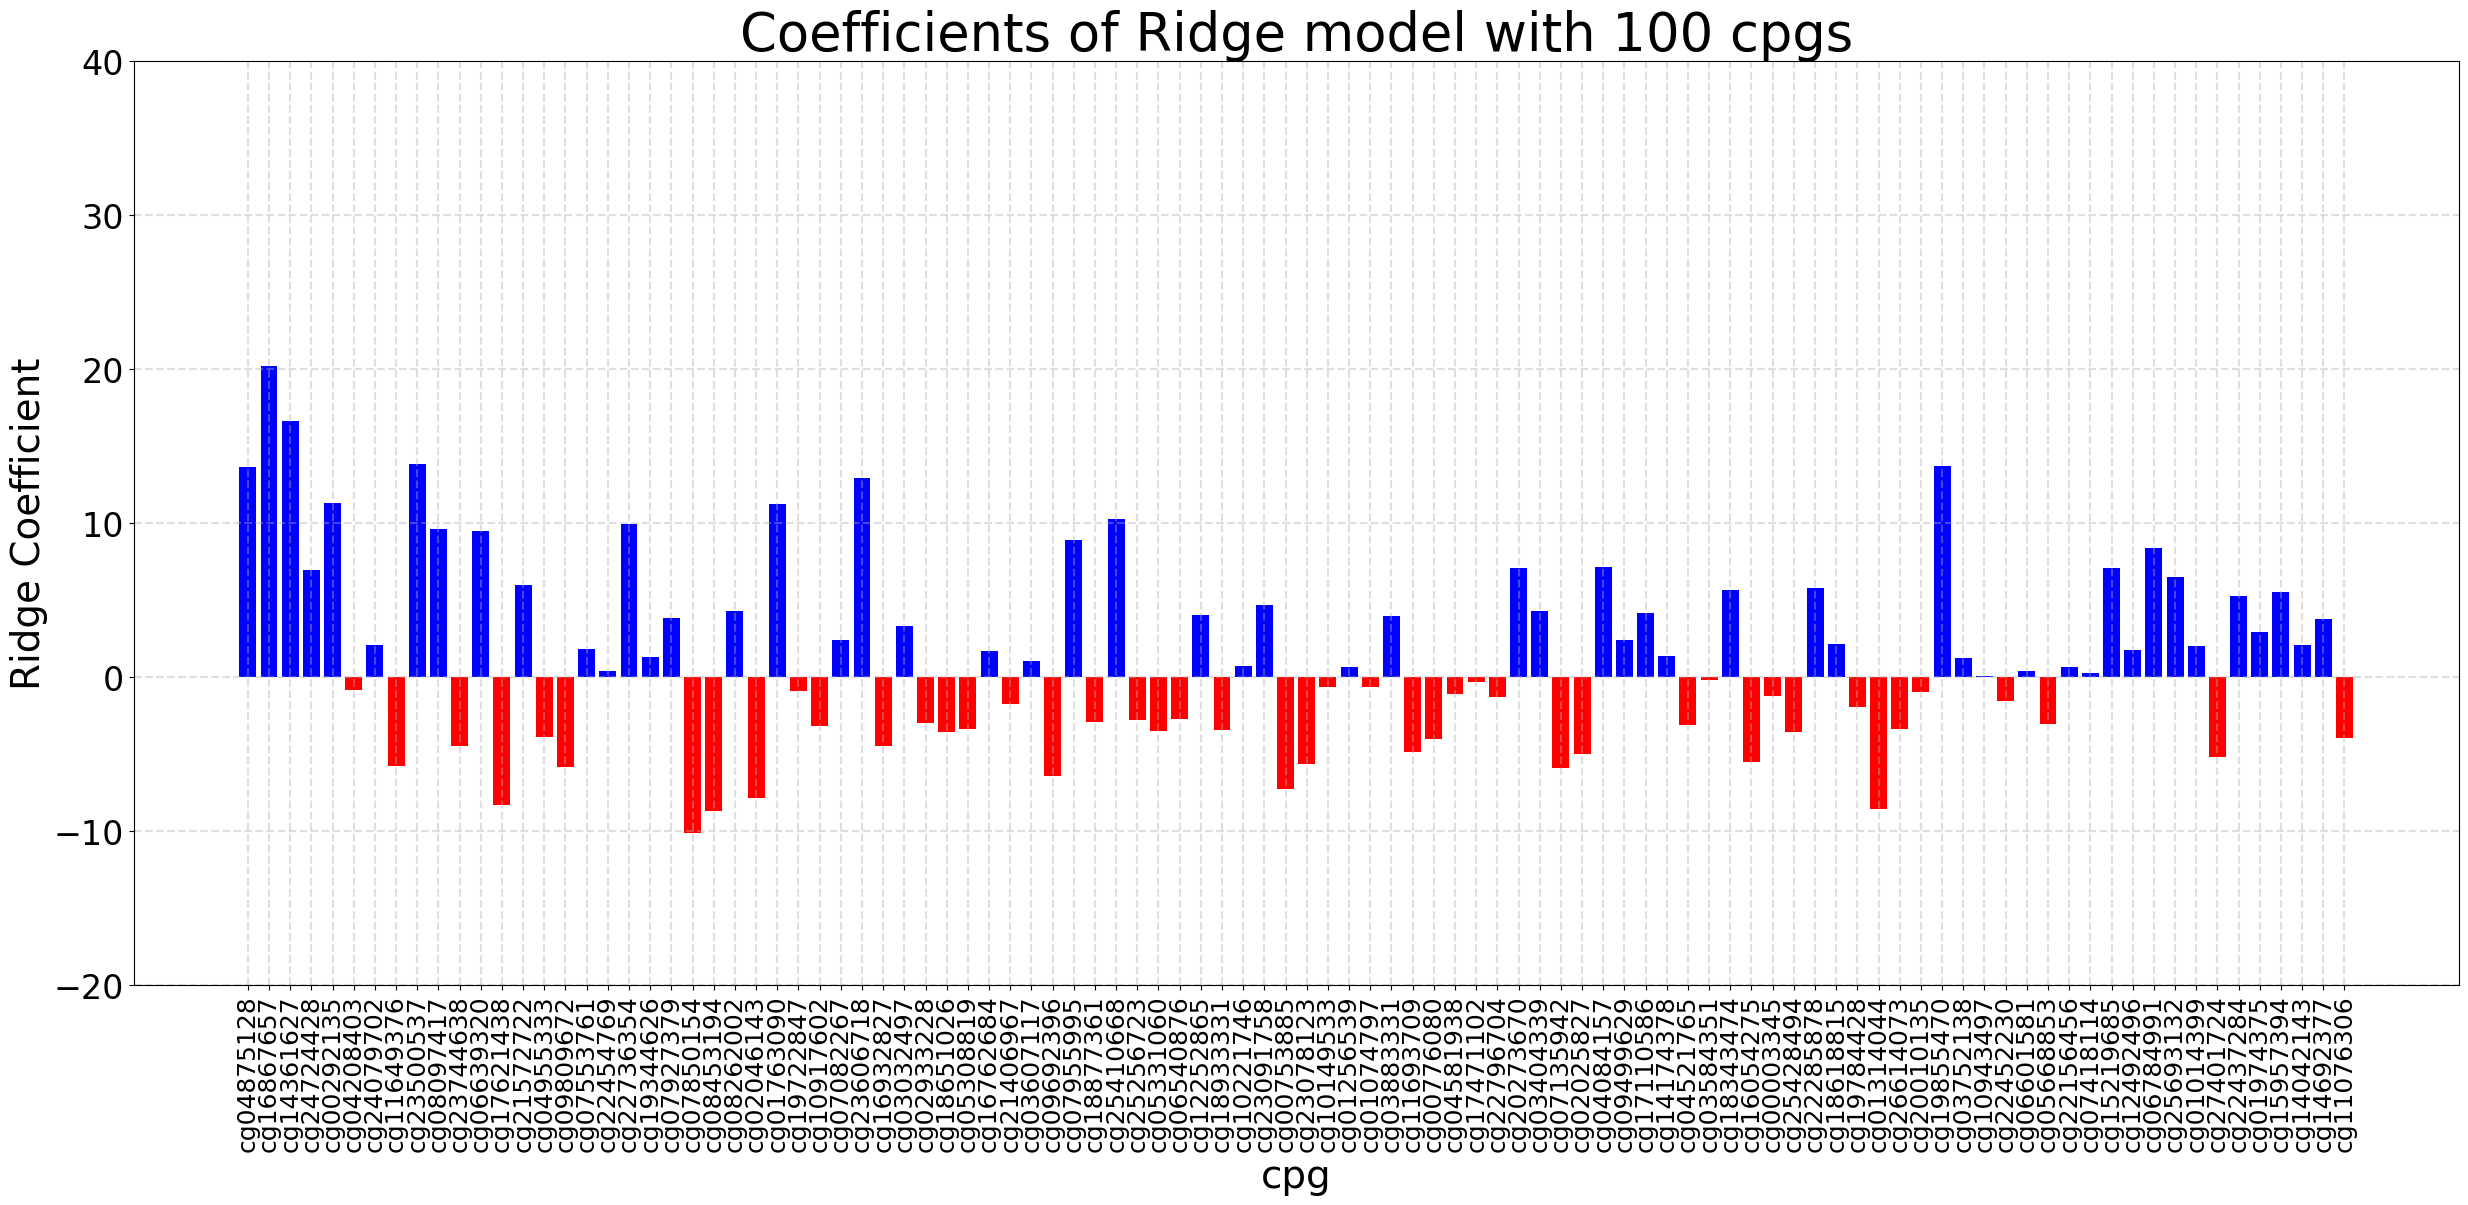

In [107]:
clrs = ['red' if x < 0 else 'blue' for x in ridge_100_coeficients ]
plt.figure(figsize = (30, 12))
plt.bar(top_100, ridge_100_coeficients, color=clrs)
plt.xlabel('cpg', fontsize=28)
plt.ylabel('Ridge Coefficient', fontsize=28)
plt.ylim(-20, 40)
plt.yticks(fontsize=24)
plt.xticks(fontsize=18, rotation=90)
plt.grid(True, lw=1.5, ls='--', alpha=0.4)
plt.title('Coefficients of Ridge model with 100 cpgs', fontsize=38)
plt.show()

In [108]:
abs_ridge  = np.abs(ridge_100_coeficients)

(0.0, 1.0)

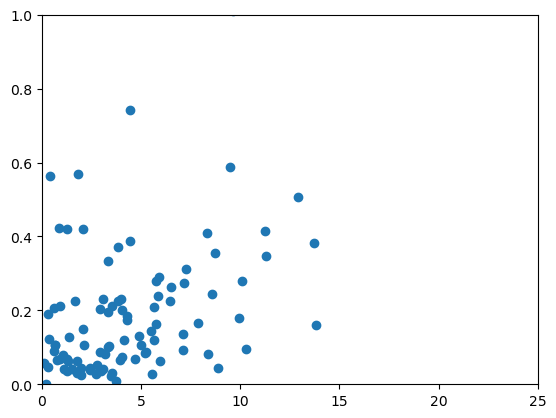

In [115]:
plt.scatter(abs_ridge, df_shap.mean_abs_shape)
plt.xlim(0, 25)
plt.ylim(0, 1)